In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = Path('/content/drive/MyDrive/CIS581/581_final_project/library')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

10 mapping images


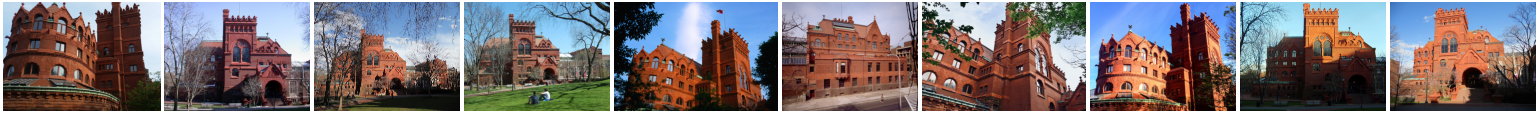

In [ ]:
references = [str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/12/03 00:00:53 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth


  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[2023/12/03 00:01:08 hloc INFO] Finished exporting features.
[2023/12/03 00:01:08 hloc INFO] Found 45 pairs.
[2023/12/03 00:01:08 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv.pth


  0%|          | 0.00/45.4M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/45 [00:00<?, ?it/s]

[2023/12/03 00:01:17 hloc INFO] Finished exporting matches.


In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2023/12/03 00:01:17 hloc INFO] Creating an empty database...
[2023/12/03 00:01:18 hloc INFO] Importing images into the database...
[2023/12/03 00:01:18 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2023/12/03 00:01:18 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2023/12/03 00:01:18 hloc INFO] Performing geometric verification of the matches...
[2023/12/03 00:01:27 hloc INFO] Running 3D reconstruction...
[2023/12/03 00:01:41 hloc INFO] Reconstructed 1 model(s).
[2023/12/03 00:01:41 hloc INFO] Largest model is #0 with 10 images.
[2023/12/03 00:01:41 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 3128
	num_observations = 10346
	mean_track_length = 3.30754
	mean_observations_per_image = 1034.6
	mean_reprojection_error = 0.972992
	num_input_images = 10


and display the reconstructed 3D model:

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

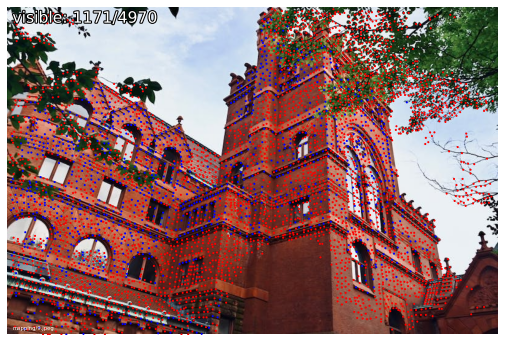

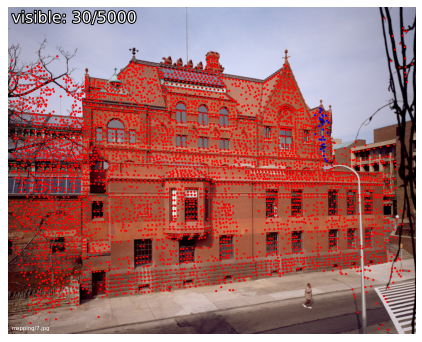

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)